In [1]:
# automatically update imports
%load_ext autoreload
%autoreload 2

# For graphs
%matplotlib inline

# snippet for relative imports
import os
import sys
module_path = os.path.abspath(os.path.join('..'))
if module_path not in sys.path:
    sys.path.append(module_path)

In [2]:
import numpy as np

city_refs = ['dublin_pleasanton', 'girona', 'sant_feilu', 'sierra_vista']
bboxes = { city_ref : bbox for city_ref, bbox in zip(city_refs, [[37.6248, -121.9603, 37.7296, -121.8202], [41.9262, 2.7692, 42.0237, 2.8489], [41.3700, 2.0203, 41.3973, 2.0774], [31.5109, -110.3800, 31.5816, -110.2052]]) }
steps = np.arange(0.005, 0.0005, -0.0005)

In [3]:
import osm_loader

poiss = { city_ref : osm_loader.pois_from_bbox(bboxes[city_ref]) for city_ref in city_refs }

In [8]:
import kde

activity_step_kdes = { city_ref : {step: kde.get_grid_category_kde(poiss[city_ref], bboxes[city_ref], step) for step in steps} for city_ref in city_refs }

In [23]:
import pandas as pd

import spatial_measures
from utils import grid_from_bbox

measure_methods = { 'geary' : spatial_measures.geary_index, 'moran' : spatial_measures.moran_index }
measure_pre_methods = { 'count' : spatial_measures.grid_cell_pois_count, 'kde' : spatial_measures.grid_cell_kde_average }
measure_series = {}

for city_ref in city_refs:
    print(city_ref)
    activity_step_kde = activity_step_kdes[city_ref]
    bbox = bboxes[city_ref]
    pois = poiss[city_ref]
    for measure_key, measure_method in measure_methods.items():
        measure_ser = {}
        for pre_key, pre_method in measure_pre_methods.items():
            pre_ser = []
            for step in steps:
                xx, yy = grid_from_bbox(bbox, step)
                if pre_key == 'count':
                    ff = pre_method(pois, xx, yy)
                else:
                    ff = pre_method(activity_step_kde[step])
                pre_ser.append(measure_method(ff, xx, yy))
            measure_ser[pre_key] = pd.Series(pre_ser, index=steps)
    measure_series[city_ref] = measure_ser

KeyError: 16

girona


dublin_pleasanton


[array([ 1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,
        1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,
        1.,  1.,  1.]), array([ 0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,
        0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,
        0.,  0.,  0.])]


ValueError: x and y must have same first dimension

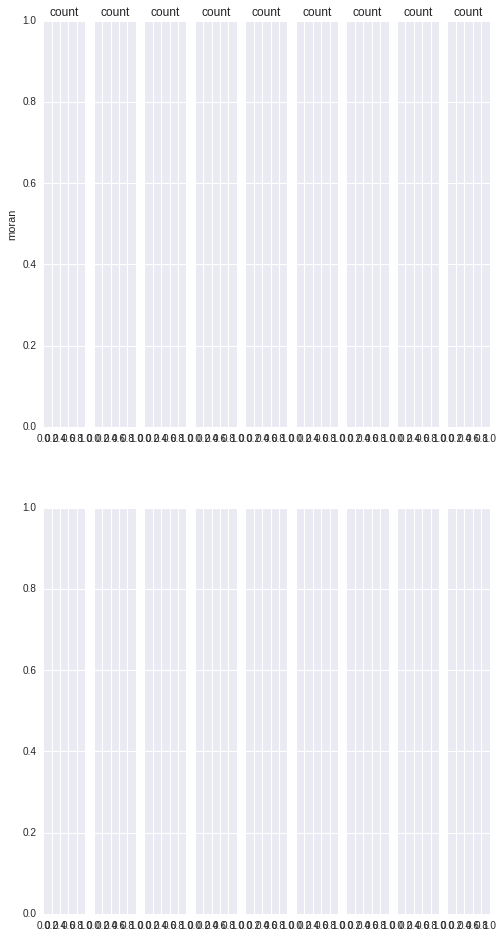

ValueError: x and y must have same first dimension

In [309]:
import matplotlib.pyplot as plt
import seaborn as sns

n_methods = len(measures)
n_measures = len(measures[0])
step_values = [kdes[s].values.size for s in range(len(steps))]

# %matplotlib qt
fig, axes = plt.subplots(n_methods, n_measures, sharey=True, figsize=(4 * n_methods, 4 * n_cities))
for method, measure_list, axs in zip(['count', 'kde'], measures, axes):
    [ax.set_title(method) for ax in axs]
    for label, measure, ax in zip(['moran', 'geary'], measure_list, axs):
        print(measure)
        ax.set_ylabel(label, rotation=90)
        ax.plot(step_values, measure)

plt.show()

In [307]:
bbox = bboxes[0]
pois = poiss[0]
kdes = category_kdes[0]
count_measures = []
kde_measures = []

for s, step in enumerate(steps):
    # TODO: add entropy when calculable for 'count'
    f = kdes[s].values
    xx, yy = kde._grid_from_bbox(bbox, step)
    count_f = spatial_measures.grid_cell_pois_count(pois, xx, yy)
    kde_f = spatial_measures.grid_cell_kde_average(f)
    
    step_count_measures = []
    step_count_measures.append(spatial_measures.moran_index(count_f, xx, yy))
    step_count_measures.append(spatial_measures.geary_index(count_f, xx, yy))
    count_measures.append(step_count_measures)
    
    step_kde_measures = []
    step_kde_measures.append(spatial_measures.moran_index(kde_f, xx, yy))
    step_kde_measures.append(spatial_measures.geary_index(kde_f, xx, yy))
    kde_measures.append(step_kde_measures)

measures = [count_measures, kde_measures]

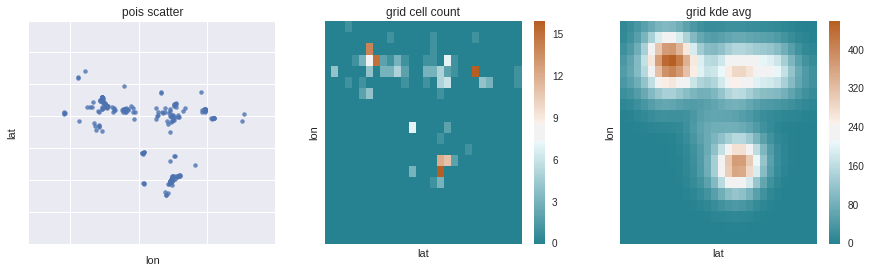

In [304]:
import seaborn as sns

shape = xx.shape[0]-1, xx.shape[1]-1
count_mat = spatial_measures.grid_cell_pois_count(pois, xx, yy).reshape(shape)
kde_mat = spatial_measures.grid_cell_kde_average(f).reshape(shape)

%matplotlib inline
hm_kwargs = {'cmap': sns.diverging_palette(210, 30, s=90, sep=20, as_cmap=True), 'xticklabels': False, 'yticklabels': False}
fig, axes = plt.subplots(1,3, figsize=(15, 4))
axes[0].set_title('pois scatter')
sns.regplot('lon', 'lat', data=pois, ax=axes[0], fit_reg=False)
axes[0].xaxis.set_ticklabels([])
axes[0].yaxis.set_ticklabels([])

for ax, title, mat in zip(axes[1:], ['grid cell count', 'grid kde avg'], map(np.flipud, [count_mat, kde_mat])):
    ax.set_title(title)
    sns.heatmap(mat, ax=ax, **hm_kwargs)
    ax.set_xlabel('lat')
    ax.set_ylabel('lon')


plt.show()

ValueError: x and y must have same first dimension

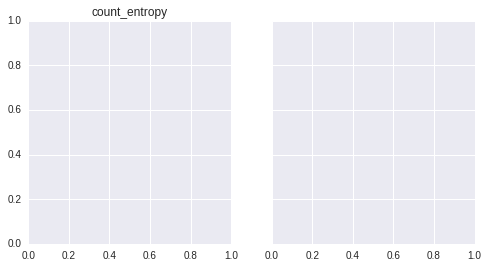

ValueError: x and y must have same first dimension

In [232]:
import matplotlib.pyplot as plt

n_measures = len(measures)

%matplotlib qt
fig, axes = plt.subplots(1, n_measures, sharey=True, figsize=(4 * n_measures, 4 * 1))
step_values = [kdes[s].values.size for s in range(len(steps))]
for title, measure, ax in zip(['count_entropy', 'kde_entropy'], measures, axes):
    ax.set_title(title)
    ax.plot(step_values, measure)

plt.show()

In [0]:
for i, city_ref in enumerate(city_refs):
    print('Indices for %s' % city_ref)
    for label, value in zip(['moran', 'geary', 'entropy'], measures):
        print('\t%s : %f' % (label, value[i][-1]))